In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

from utilities2014 import *

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=1)
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
neighbors = dm.load_pipeline_result('neighbors', 'pkl')
sp_properties = dm.load_pipeline_result('spProps', 'npy')
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [4]:
features = dm.load_pipeline_result('features', 'npy').astype(np.float)

In [5]:
features = np.rollaxis(features, 0, 3)

In [6]:
max_freqs, max_angles = np.unravel_index(features.argmax(axis=2), (dm.n_freq, dm.n_angle))
max_responses = features.max(axis=2)
max_mean_ratio = max_responses/features.mean(axis=2)

In [7]:
from joblib import Parallel, delayed

def worker(i):
    chosen = segmentation == i
    
    max_response_sp = max_responses[chosen].astype(np.float).max()
    max_dir_sp = np.bincount(max_angles[chosen]).argmax()
    max_freq_sp = np.bincount(max_freqs[chosen]).argmax()
    
    all_mmr = max_mean_ratio[chosen].astype(np.float)
    dominant_ratio_sp = np.count_nonzero(all_mmr > 1.02)/float(len(all_mmr))

    return max_dir_sp, max_freq_sp, max_response_sp, dominant_ratio_sp
    
res = Parallel(n_jobs=16)(delayed(worker)(i) for i in range(n_superpixels))
max_dir_sp, max_freq_sp, max_response_sp, dominant_ratio_sp = map(np.array, zip(*res))

In [8]:
# dm.save_pipeline_result(max_dir_sp, 'spMaxDirInd', 'npy')
# dm.save_pipeline_result(dm.angles[max_dir_sp], 'spMaxDirAngle', 'npy')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular_spMaxDirInd.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0001/RS141_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular_spMaxDirAngle.npy


In [9]:
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')
segmentation_vis2 = segmentation_vis.copy()
segmentation_vis2[~dm.mask] = 0

In [10]:
hc_colors = np.loadtxt('../visualization/100colors.txt')

In [ ]:
# from skimage.color import hsv2rgb
# [hsv2rgb((i/n_freq, )) for i in range(n_freq) for j in range(n_angle)]

In [21]:
max_response_sp_normalized = (max_response_sp - max_response_sp.min())/(max_response_sp.max() - max_response_sp.min())

from skimage.util import img_as_ubyte

dirmap_vis2 = gray2rgb(segmentation_vis.copy())
# dirmap_vis2 = gray2rgb(cropped_segmentation_vis2.copy())
# dirmap_vis2 = gray2rgb(np.zeros_like(cropped_segmentation, dtype=np.uint8))
dirmap_vis2 = img_as_ubyte(dirmap_vis2)

sp_properties = dm.load_pipeline_result('spProps', 'npy')

for s in range(n_superpixels - 1):
#     if dominant_ratio_sp[s] < 0.2:
#         continue
    
    center = sp_properties[s, [1,0]].astype(np.int)
    angle = dm.angles[max_dir_sp[s]]

    length = max_response_sp_normalized[s]*100
    end = center + np.array([length*np.sin(angle), -length*np.cos(angle)], dtype=np.int)
    cv2.line(dirmap_vis2, tuple(center), tuple(end), (255,0,0), thickness=5, lineType=8, shift=0)
    
#     length = int(1./frequencies[max_freq_sp[s]])
#     end = center + np.array([length*np.cos(angle), length*np.sin(angle)], dtype=np.int)
#     cv2.line(dirmap_vis2, tuple(center), tuple(end), (255,0,0), 
#              thickness=5, lineType=8, shift=0)
    
    
#     cv2.line(dirmap_vis2, tuple(center), tuple(end), tuple(map(int, hc_colors[max_freq_sp[s]+1]*255)), 
#              thickness=5, lineType=8, shift=0)
            

In [23]:
display(dirmap_vis2)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [19]:
dm.save_pipeline_result(dirmap_vis2, 'dirMap', 'jpg')

saved /home/yuncong/project/DavidData2014results/RS140/0000/RS140_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular_dirMap.jpg


In [11]:
import networkx

In [12]:
G = networkx.Graph()

In [25]:
dm.angles[max_dir_sp[353]]

1.9547687622336491

In [26]:
dm.angles[max_dir_sp[354]]

1.9547687622336491

In [28]:
# A = np.zeros((n_superpixels, n_superpixels))
for sp in range(n_superpixels):
    sp_angle = dm.angles[max_dir_sp[sp]]
    for n in neighbors[sp]:
        neighbor_angle = dm.angles[max_dir_sp[n]]
        angle_diff = np.abs(np.cos(np.abs(neighbor_angle - sp_angle)))
#         affin = max_response_sp_normalized[sp] * max_response_sp_normalized[n] * angle_diff
        affin = angle_diff
        G.add_edge(sp, n, weight=affin)

In [30]:
G.edge[353][354]

{'weight': 1.0}

In [29]:
G.edge[249][201]

{'weight': 0.10452846326765355}

In [31]:
comp = networkx.clustering(G, weight='weight')

In [57]:
e = networkx.betweenness.edge_betweenness(G, weight='weight')

In [50]:
vmap = max_response_sp[segmentation]

In [45]:
vmap = np.array(comp.values())[segmentation]

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

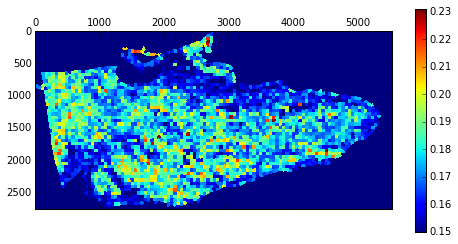

In [56]:
plt.matshow(vmap, vmin=.15);
plt.colorbar(); 